# Inspecting the results of `bmfm-multi-omics` for cell type annotation

Assigning cell type annotations is an import and time consuming part of single-cell analysis. BMFM-RNA simplifies this process by not only performing the cell-type annotation but also the preprocessing and visualisation through the embeddings created by the model.

In this tutorial we look at inspecting the results of the zero-shot prediction created in tutorial 1. We do this by loading the results of the data and then using the helper functions packaged in the `evaluation` module to help extract and interpret the results of the model.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

from bmfm_targets.evaluation.embeddings import generate_clusters, load_predictions
from bmfm_targets.evaluation.plots import (
    plot_cell_type_counts,
    plot_embeddings,
    plot_logits,
)
from bmfm_targets.evaluation.predictions import get_general_cell_type, merge_bmfm_adata

## Load Original input data

To demostrate the BMFM-RNAs abilites, we use the PBMC data created by 10X Genomics (dataset can be downloaded [here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). This dataset is created of 3k PBMCs from a Healthy Donor. The raw data will be used as the input, but we will also extract the cell type annotation from the legacy scanpy workflow as a comparison between the BMFM and classical scRNA-seq analysis. 

For more information about how the data was preprocessed please visit scanpy's tutorial [here](https://scanpy.readthedocs.io/en/1.11.x/tutorials/basics/clustering-2017.html).

In [2]:
reference_adata = sc.read_h5ad("data/pbmc3k_processed.h5ad")
reference_labels = pd.DataFrame(reference_adata.obs["louvain"])

/Users/mattmadgwick/miniforge3/envs/bmfm-tutorial/lib/python3.12/site-packages/anndata/_io/h5ad.py:242: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(
/Users/mattmadgwick/miniforge3/envs/bmfm-tutorial/lib/python3.12/site-packages/anndata/_io/h5ad.py:242: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(


## Load model outputs

First we need to convert the embeddings and barcode names into a adata object. This can be done using the `load_predictions`.

In [3]:
predictions = load_predictions(working_dir="results/pbmc3k")
bmfm_adata = predictions["adata"]
bmfm_adata.obs.head()

,cell_type,tissue,tissue_general,donor_id
cellnames,,,,
AAACATACAACCAC-1,"effector memory CD8-positive, alpha-beta T cell",bone marrow,bone marrow,D503
AAACATTGAGCTAC-1,mature B cell,bone marrow,bone marrow,HCA_BM_BM4
AAACATTGATCAGC-1,"effector memory CD8-positive, alpha-beta T cell",brain,brain,D503
AAACCGTGCTTCCG-1,dendritic cell,bone marrow,bone marrow,HCA_BM_BM3
AAACCGTGTATGCG-1,natural killer cell,lung,vasculature,7_Slysz_femoral


## Plot embeddings

To view the embeddings and paint the cell-type annotations on the UMAP the embeddings will be extracted from the results. Then you can run unsupervised clustering and UMAP projection on the embeddings from inference step.

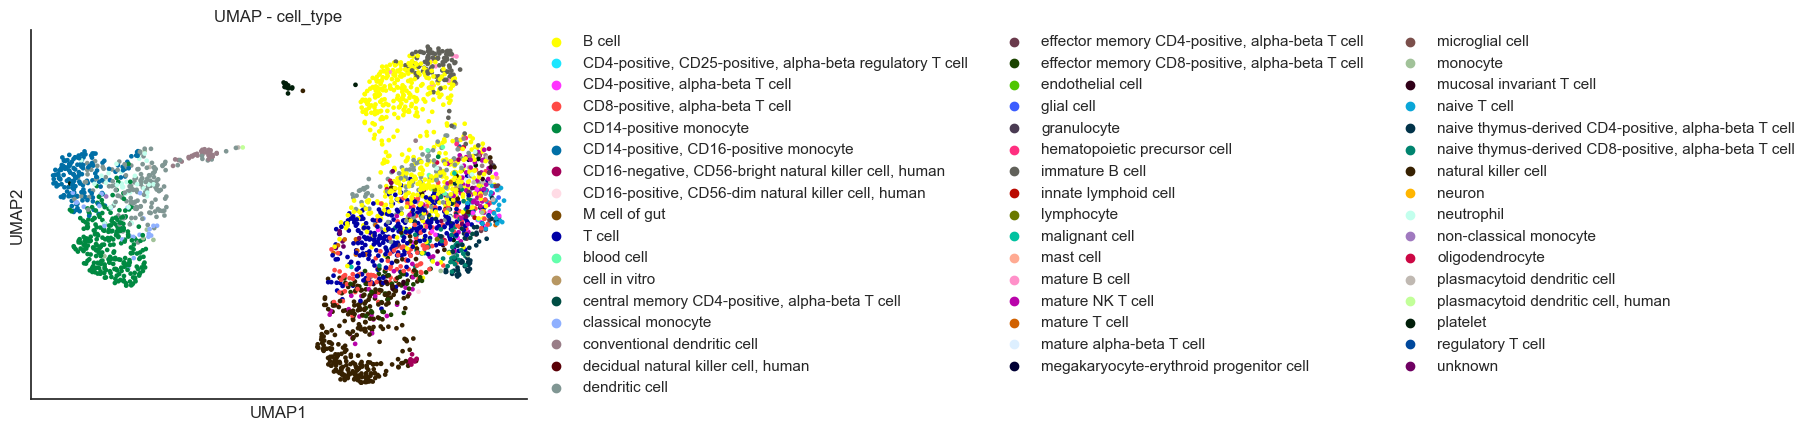

In [4]:
bmfm_adata = generate_clusters(
    bmfm_adata,
    n_components=20,
    label="cell_type",
    clustering_method="kmeans",
    n_clusters=11,
)

plot_embeddings(bmfm_adata, "cell_type")

The `bmfm.rna.bert.110m.wced.multitask.v1` model is trained on the most coarse cell labels as defined by the data on CellXGene. 

In some cases you may want to try and generalize the cell labels. To do this you can use the helper function `get_general_cell_type` and set the level to `sub_class` to create general cell annotations.

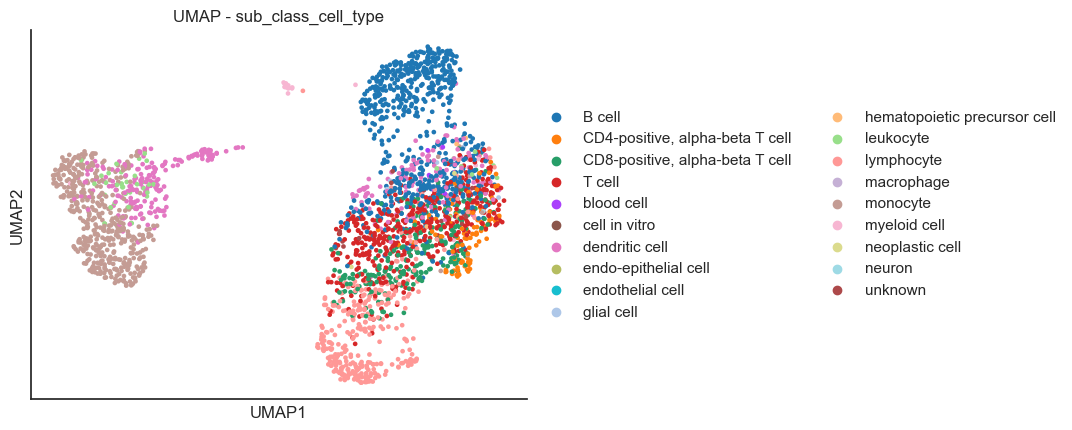

In [5]:
bmfm_adata = get_general_cell_type(bmfm_adata, level="sub_class")
plot_embeddings(bmfm_adata, "sub_class_cell_type")

The original labelling of the PMBC3K dataset can then also be projected onto the UMAP here as the ground truth labels to observe the how similar the are to the predicted cell type labels.

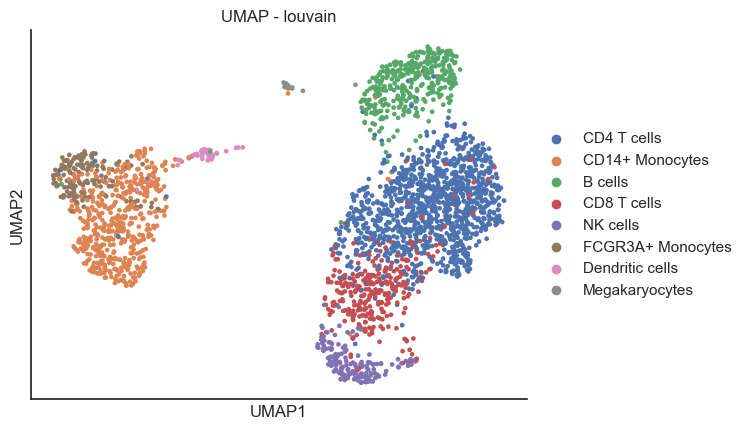

In [6]:
bmfm_adata.obs = bmfm_adata.obs.join(reference_labels, how="left")
plot_embeddings(bmfm_adata, "louvain")

We can then compare the cell counts between our ground truth labels and our sub-class summarized predicted labels from the model:

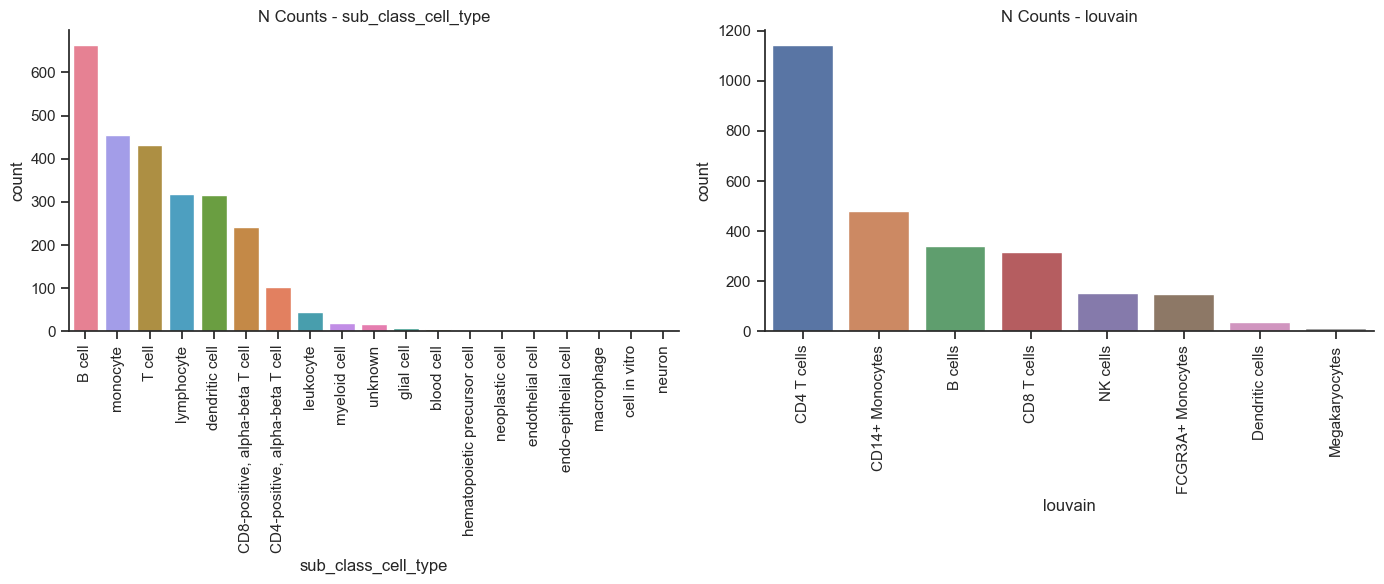

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_cell_type_counts(bmfm_adata, "sub_class_cell_type", ax=axes[0], show=False)
plot_cell_type_counts(bmfm_adata, "louvain", ax=axes[1], show=False)
plt.tight_layout()
plt.show()

## Plotting Logits

You can observe the prediction for each individual cell using the logits from the checkpoint.

/Users/mattmadgwick/miniforge3/envs/bmfm-tutorial/lib/python3.12/site-packages/scanpy/plotting/_utils.py:481: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


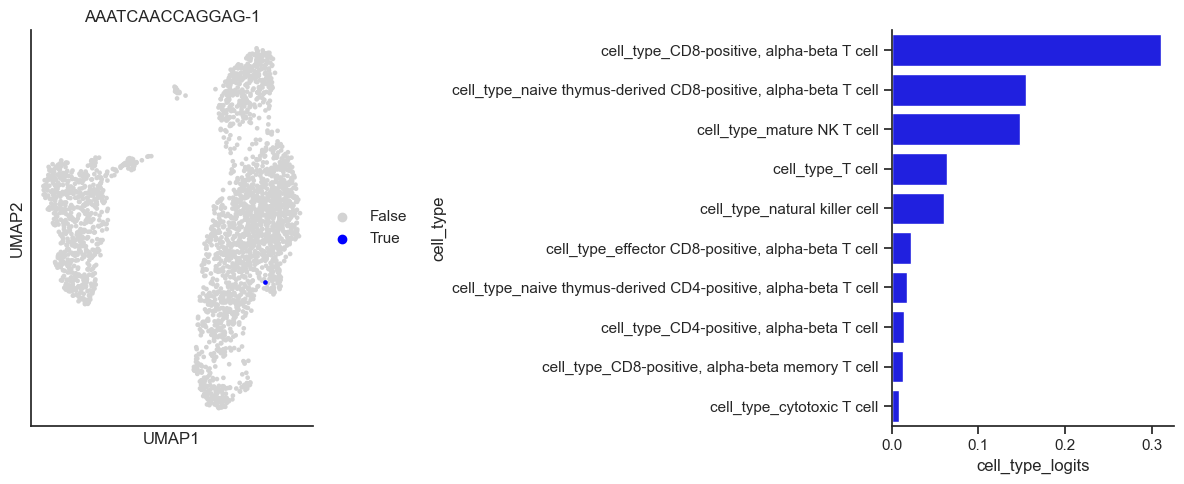

In [8]:
plot_logits("AAATCAACCAGGAG-1", "cell_type", predictions, bmfm_adata)

## Merge BMFM embedding with original adata object

Now we have observed the cell type prediction, embedding and looked at the cell type predictions in more detail. You might now want to combine this data with your original dataset. 

We can do this by merging the adata objects and setting the embedding and UMAP created by the model through setting the embeddings to `.obsm` from the original `.X`.

There is a helper function `merge_bmfm_adata`:

In [9]:
adata_merged = merge_bmfm_adata(bmfm_adata, reference_adata)
adata_merged

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain_bmfm', 'cell_type', 'tissue', 'tissue_general', 'donor_id', 'kmeans', 'sub_class_cell_type', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'X_bmfm'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [10]:
adata_merged.obs.head()

,n_genes,percent_mito,n_counts,louvain_bmfm,cell_type,tissue,tissue_general,donor_id,kmeans,sub_class_cell_type,louvain
index,,,,,,,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,"effector memory CD8-positive, alpha-beta T cell",bone marrow,bone marrow,D503,0,"CD8-positive, alpha-beta T cell",CD4 T cells
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,mature B cell,bone marrow,bone marrow,HCA_BM_BM4,4,B cell,B cells
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,"effector memory CD8-positive, alpha-beta T cell",brain,brain,D503,3,"CD8-positive, alpha-beta T cell",CD4 T cells
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,dendritic cell,bone marrow,bone marrow,HCA_BM_BM3,2,dendritic cell,CD14+ Monocytes
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,natural killer cell,lung,vasculature,7_Slysz_femoral,8,lymphocyte,NK cells


Once merged, you can then overlap gene expression values on the emebeddings to see which clusters/cell types enriched with your gene of interest. 

For example here we are looking CST3 for B-cells, NKG7 for Natural Killer Cells and CD8A for CD8+ T Cells.

<Figure size 1200x800 with 0 Axes>

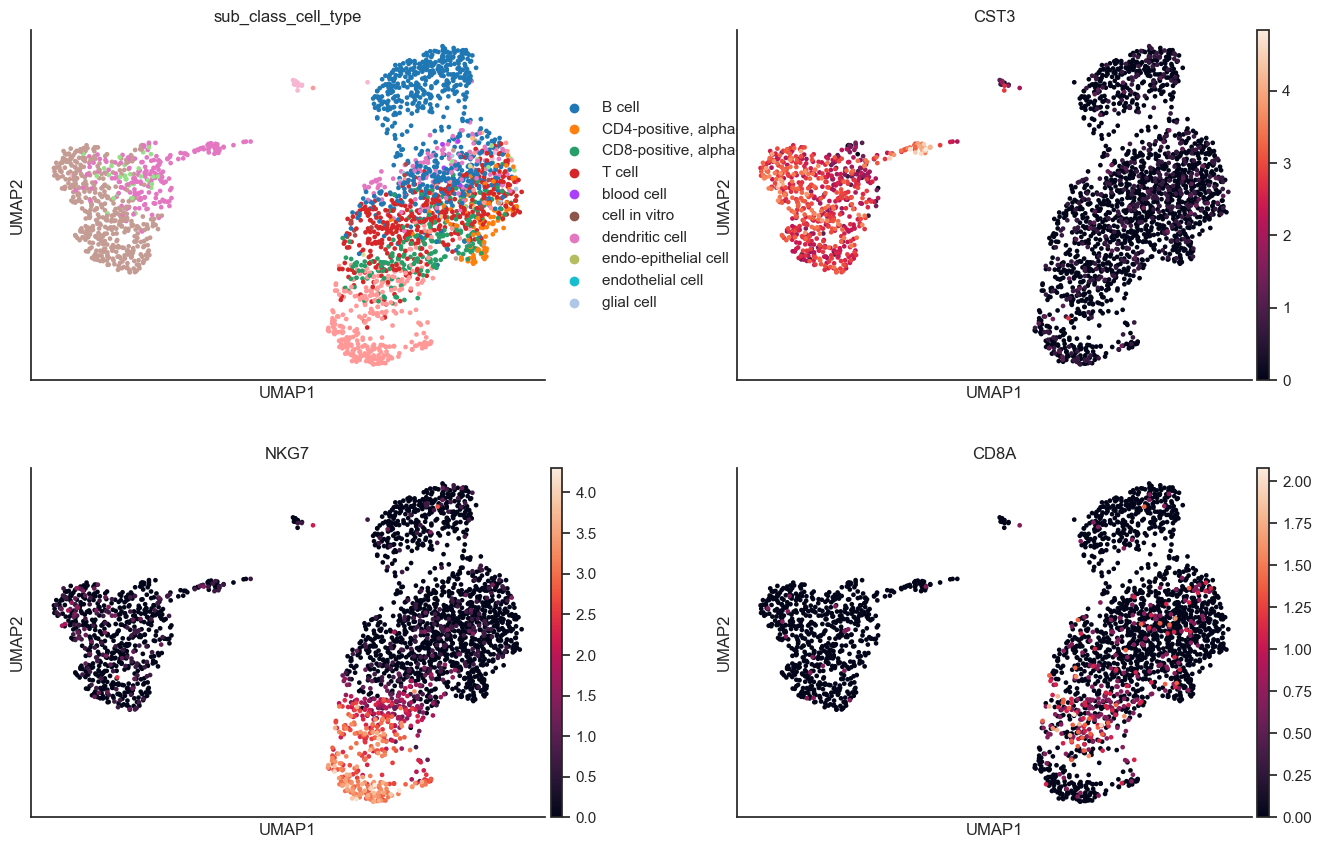

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(12, 8))
sc.pl.umap(
    adata_merged,
    color=["sub_class_cell_type", "CST3", "NKG7", "CD8A"],
    ncols=2,
    wspace=0.25,
)
plt.tight_layout()

## Save adata object

Finally, you can save the adata object with the cell types and BMFM embedding using the scanpy's `.write_h5ad()` and save the results from the model as a pickle file.

In [12]:
results_dir = Path("results")
adata_merged.write_h5ad(results_dir / "bmfm_pbmc3k.h5ad")